In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
from pathlib import Path
import random

import pandas as pd
from matplotlib import colors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Import datasets

Training dataset

In [3]:
hands_path = 'Dataset/Training-Dataset/Images/'
masks_path = 'Dataset/Training-Dataset/Masks-Ideal/'

hands_files = Path(hands_path).glob('*.jpg')
masks_files = Path(masks_path).glob('*.bmp')

masks_file_names = []
hands_file_names = []

for file in hands_files: 
    hands_file_names.append(file.name)
    
for file in masks_files: 
    masks_file_names.append(file.name)

In [4]:
# Comprobamos que coincidan los archivos
hands_file_names.sort()
masks_file_names.sort()

print(hands_file_names[:5])
print(30*"-")
print(masks_file_names[:5])

print( len(hands_file_names), len(masks_file_names))

['0_A_hgr2B_id01_1.jpg', '0_A_hgr2B_id02_1.jpg', '0_A_hgr2B_id03_1.jpg', '0_A_hgr2B_id04_1.jpg', '0_A_hgr2B_id05_1.jpg']
------------------------------
['0_A_hgr2B_id01_1.bmp', '0_A_hgr2B_id02_1.bmp', '0_A_hgr2B_id03_1.bmp', '0_A_hgr2B_id04_1.bmp', '0_A_hgr2B_id05_1.bmp']
101 101


In [5]:
hand_images = []
for pathImg in hands_file_names:
  image = cv.imread(hands_path+pathImg)

  # convert from BGR to yCbCr colorspace for easier classification later
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  hand_images.append(image)

mask_images = []
for pathImg in masks_file_names:
  image = cv.imread(masks_path+pathImg)
  mask_images.append(image)

In [6]:
# Normalizamos los valores de la imagen original y de la máscara entre 0 y 1
for i in tqdm(range(len(hand_images))):
  mask, g, r = cv.split(mask_images[i])
  # hand_images[i] = hand_images[i].astype('float32')
  hand_images[i] = np.array(hand_images[i], dtype=np.float32) / 255
  mask_images[i] = mask.astype('float32') / 255


100%|██████████| 101/101 [00:00<00:00, 170.62it/s]


In [7]:
print(hand_images[0].shape)
print(mask_images[0].shape)

(604, 400, 3)
(604, 400)


## EDA Images

In [8]:
def plot_colours(df, c1, c2, c3, photo):
    """
    Given a DataFrame and three column names,
    plot the pairs against each other
    """
    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(18, 6)
    df.plot.scatter(c1, c2, c=df["colour"], alpha=0.3, ax=ax[0])
    df.plot.scatter(c1, c3, c=df["colour"], alpha=0.3, ax=ax[1])
    df.plot.scatter(c2, c3, c=df["colour"], alpha=0.3, ax=ax[2])

    plt.imshow(photo)
    

In [9]:
# test_img = hand_images[10]
# rgb_img = np.array(test_img, dtype=np.float32) / 255
rgb_img = hand_images[60]
hsv_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2HSV)

/Users/ivan/opt/anaconda3/envs/dev/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


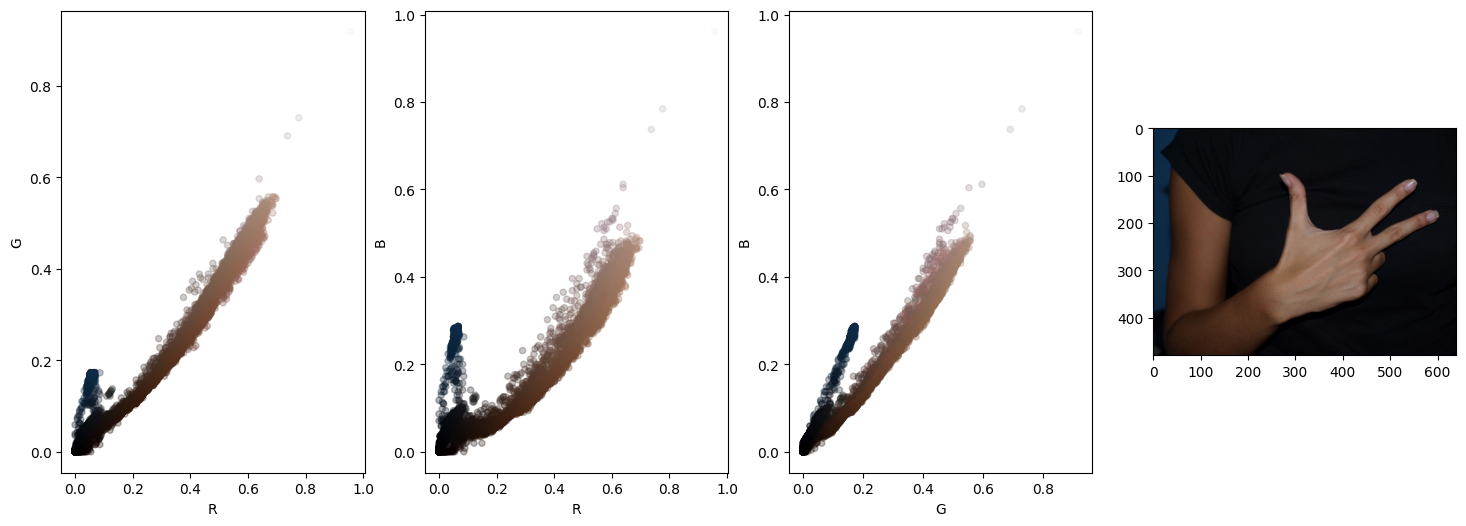

In [10]:
columns=["R", "G", "B"]
w, h, d = original_shape = tuple(rgb_img.shape)  # Get the current shape
rgb_image_array = np.reshape(rgb_img, (w * h, d))  # Reshape to to 2D
pixels = pd.DataFrame(rgb_image_array, columns=columns)
pixels["colour"] = [colors.to_hex(p) for p in rgb_image_array]
pixels_sample = pixels.sample(frac=0.05)

%matplotlib inline
plot_colours(pixels_sample, "R", "G", "B", rgb_img)

/Users/ivan/opt/anaconda3/envs/dev/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


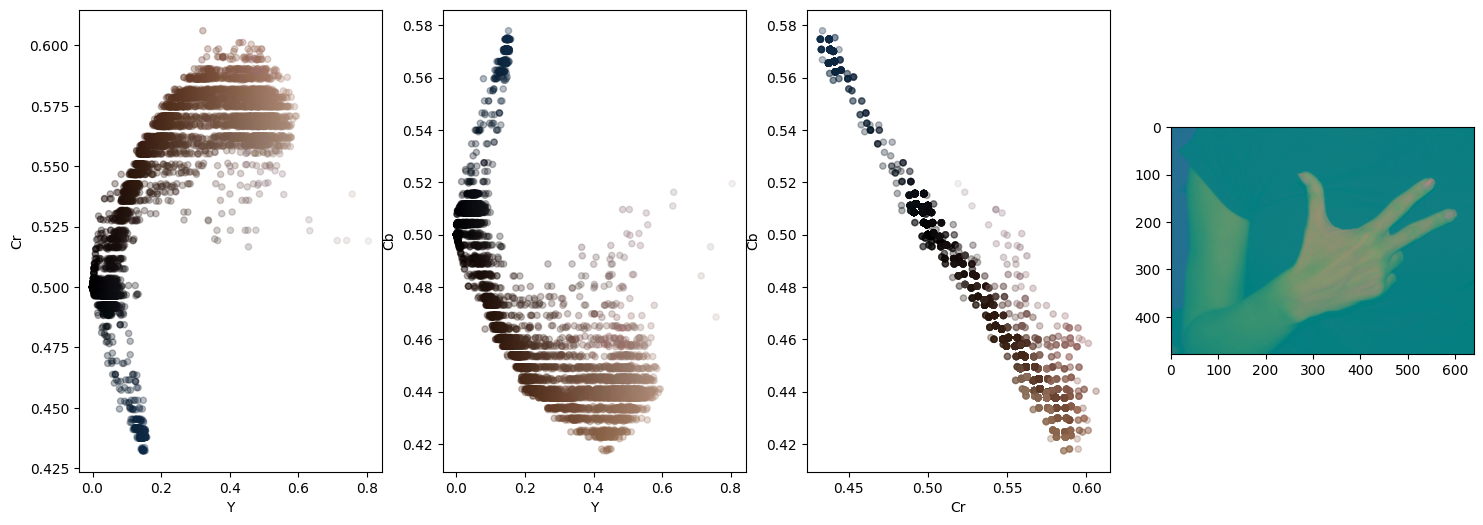

In [11]:
yCbCr_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2YCrCb)
columns=["Y", "Cr", "Cb"]
w, h, d = original_shape = tuple(yCbCr_img.shape)  # Get the current shape
image_array = np.reshape(yCbCr_img, (w * h, d))  # Reshape to to 2D
pixels = pd.DataFrame(image_array, columns=columns)
pixels["colour"] = [colors.to_hex(p) for p in rgb_image_array]
pixels_sample = pixels.sample(frac=0.05)

%matplotlib inline
plot_colours(pixels_sample, "Y", "Cr", "Cb", yCbCr_img)

/Users/ivan/opt/anaconda3/envs/dev/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


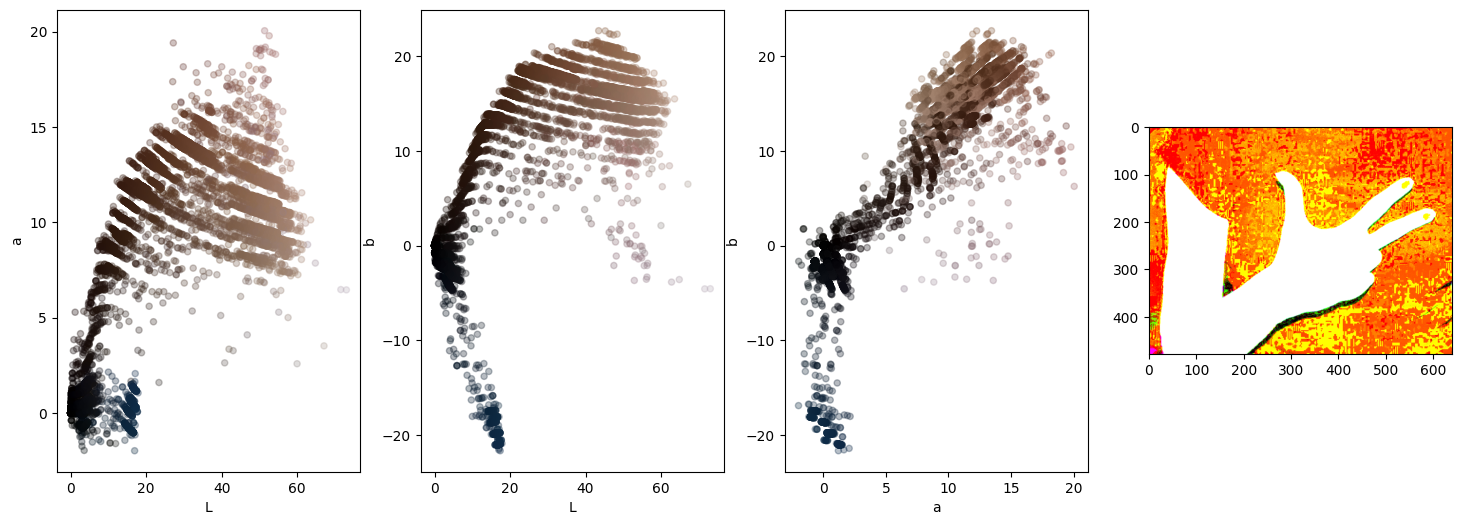

In [247]:
lab_img = cv.cvtColor(rgb_img, cv.COLOR_RGB2LAB)
columns=["L", "a", "b"]
w, h, d = original_shape = tuple(lab_img.shape)
image_array_lab = np.reshape(lab_img, (w * h, d))
pixels_lab = pd.DataFrame(image_array_lab, columns=columns)
pixels_lab["colour"] = [colors.to_hex(p) for p in rgb_image_array]
pixels_sample_lab = pixels_lab.sample(frac=0.05)

plot_colours(pixels_sample_lab, "L", "a", "b", lab_img)

In [ ]:
plt.imshow(rgb_img)

## Preprocessing

In [234]:
flat_imgs = []
flat_masks = []
for i in tqdm(range(len(hand_images))):
  new_img = hand_images[i].reshape(-1, 3)
  flat_imgs.append(new_img)

  # invertimo la máscara para que los 1 corresponda a la mano
  new_mask = mask_images[i]*-1+1
  flat_masks.append(new_mask.reshape(-1, 1))

  # print(new_mask.shape, hand_images[i].shape)

100%|██████████| 101/101 [00:00<00:00, 545.01it/s]


In [235]:
print(flat_imgs[0].shape)
print(flat_masks[0].shape)
print(604*400)

(241600, 3)
(241600, 1)
241600


## Model 1: Logistic regression

In [236]:
X = np.concatenate(flat_imgs[:200])
y = np.concatenate(flat_masks[:200])

print(X.shape, y.shape)



(21825092, 3) (21825092, 1)


In [237]:
# print(len(X), len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [238]:
print(X_train.shape, y_train.shape)

(15277564, 3) (15277564, 1)


In [239]:
model_lr = LogisticRegression(verbose = True)
model_lr.fit(X_train, y_train)

/Users/ivan/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05896D+07    |proj g|=  4.12322D+06


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   5.762D+00   3.564D+06
  F =   3563829.0714878100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s finished


LogisticRegression(verbose=True)

In [240]:
# Check accuracy metric
print(model_lr.score(X_train, y_train))
print(model_lr.score(X_test, y_test))

0.9220458837547661
0.9222147656336865


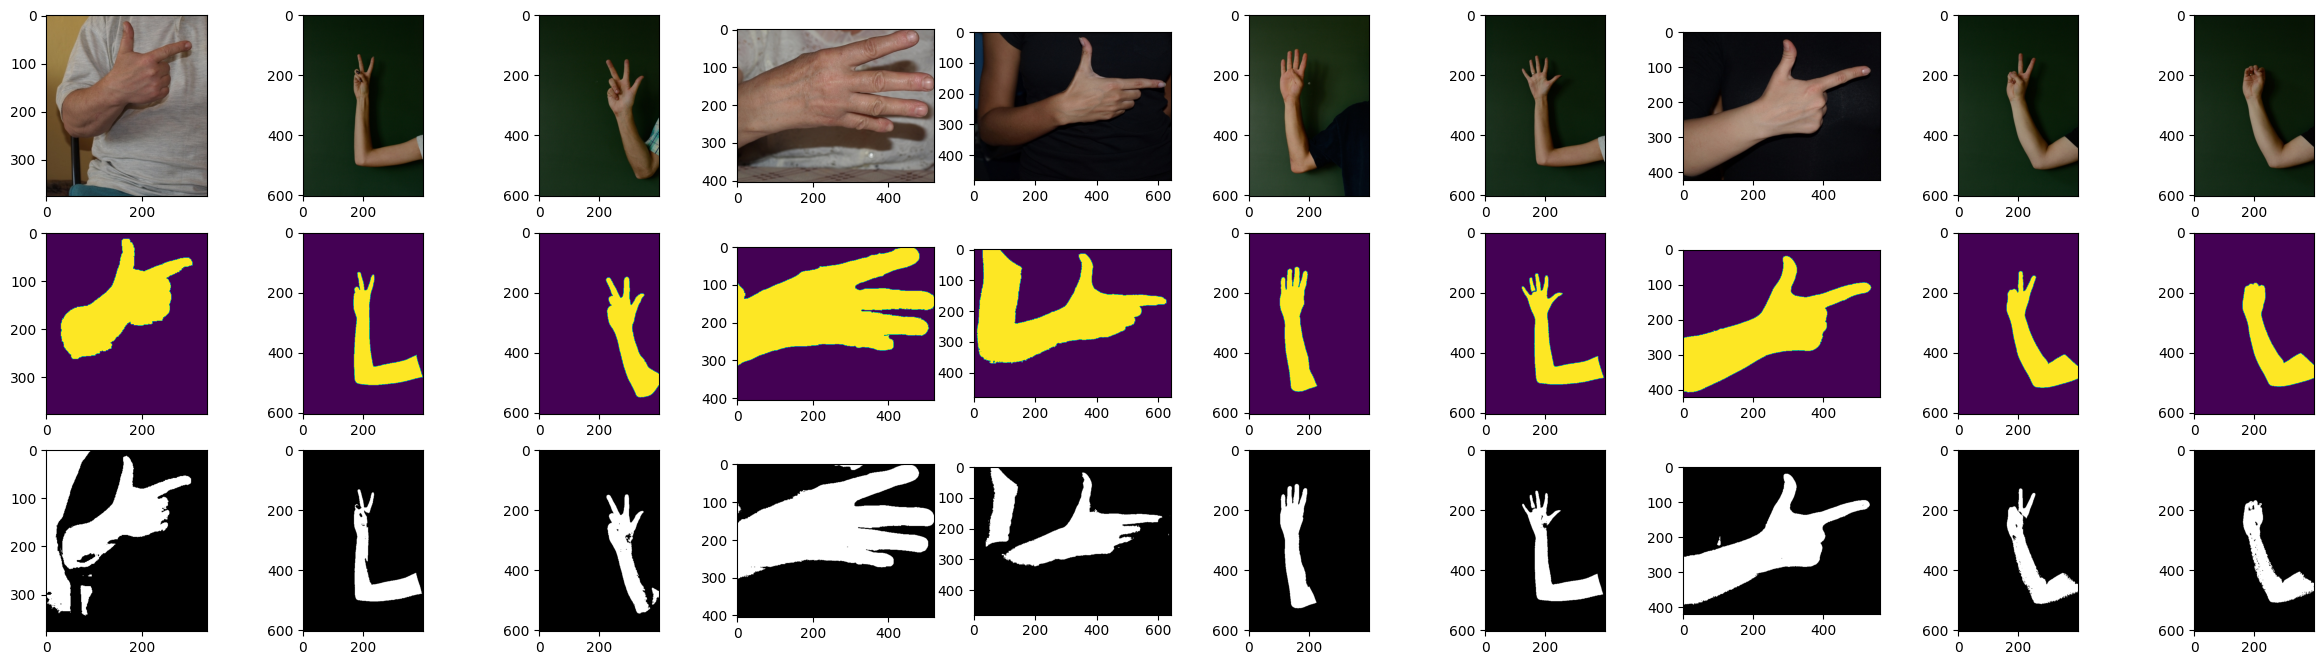

In [313]:
# Build a dashboard to see how the model performs on random examples

# Choose how many examples we want
k = 10

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=3, ncols=k, figsize=(3*k, 8))

# Cycle through a random selection of k images
for i, j in enumerate(random.sample(range(len(hand_images)), k)):

  example_img = hand_images[j]
  example_mask = mask_images[j]

  # Pre-process the images to feed them to the Model
  flat_ex = example_img.reshape((-1, 3))

  # Feed the images through the model
  pred_mask = (model_lr.predict_proba(flat_ex)[:, 1] > 0.6)

  # Reshape the output back to a 2-D image format
  pred_mask = pred_mask.reshape(example_img.shape[:2])

  # Show the original image, predicted map and ground truth map
  # ax[0, i].imshow(cv.cvtColor(example_img,cv.COLOR_RGB2BGR))
  ax[0, i].imshow(example_img)
  ax[1, i].imshow((-1*example_mask+1)*255)
  ax[2, i].imshow(pred_mask*255, cmap='gray')

## Validation dataset

In [296]:
hands_path_val = 'Dataset/Validation-Dataset/Images/'
masks_path_val = 'Dataset/Validation-Dataset/Masks-Ideal/'

hands_files_val = Path(hands_path_val).glob('*.jpg')
masks_files_val = Path(masks_path_val).glob('*.bmp')

masks_file_val = []
hands_file_val = []

for file in hands_files_val: 
    hands_file_val.append(file.name)
    
for file in masks_files_val: 
    masks_file_val.append(file.name)

In [309]:
# Comprobamos que coincidan los archivos
hands_file_val.sort()
masks_file_val.sort()

print(hands_file_val[-1])
print(30*"-")
print(masks_file_val[-1])

5_P_hgr1_id08_3.jpg
------------------------------
5_P_hgr1_id08_3.bmp


In [293]:
hands_path_val

'Dataset/Validation-Dataset/Images/'

In [316]:
hand_val = []
for pathImg in hands_file_val:
  image = cv.imread(hands_path_val+pathImg)
  # convert from BGR to yCbCr colorspace for easier classification later
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  hand_val.append(image)

mask_val = []
for pathImg in masks_file_val:
  image = cv.imread(masks_path_val+pathImg)
  mask_val.append(image)

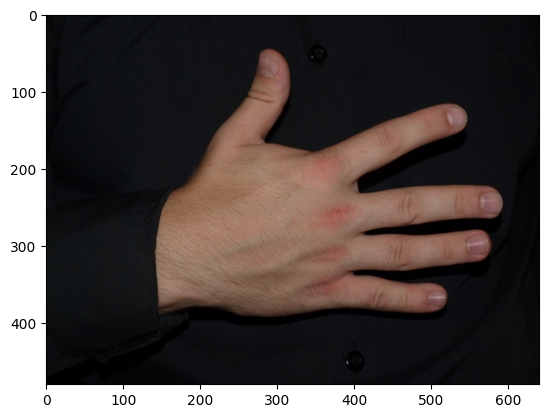

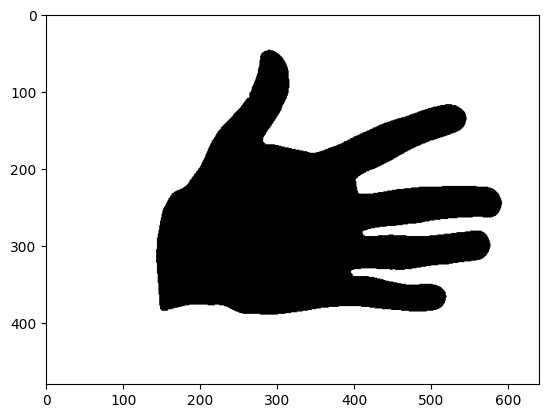

: 

In [318]:
plt.imshow(hand_val[-1])
plt.figure()
plt.imshow(mask_val[-1])

In [311]:
# Normalizamos los valores de la imagen original y de la máscara entre 0 y 1
for i in tqdm(range(len(hand_val))):
  mask, g, r = cv.split(mask_val[i])
  # hand_images[i] = hand_images[i].astype('float32')
  hand_val[i] = np.array(hand_images[i], dtype=np.float32)
  mask_val[i] = mask.astype('float32') / 255

100%|██████████| 77/77 [00:00<00:00, 141.31it/s]


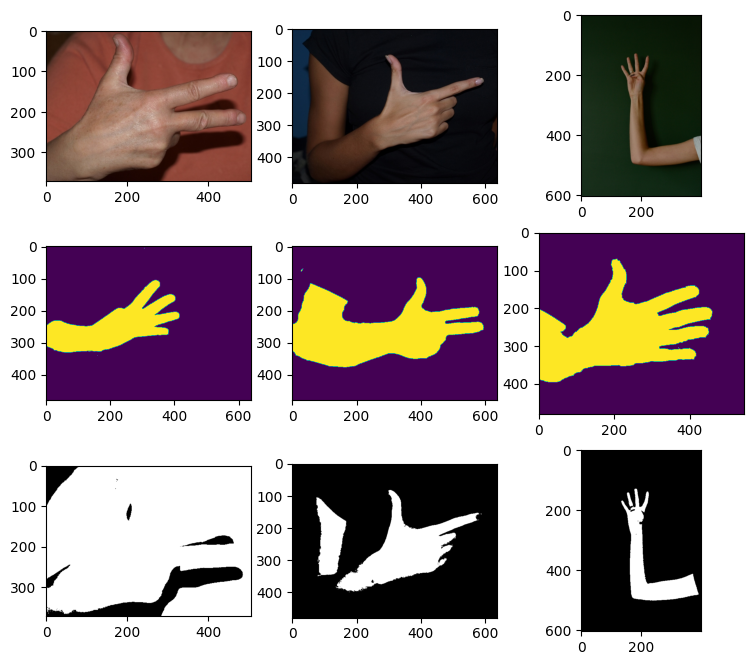

In [301]:
# Build a dashboard to see how the model performs on random examples

# Choose how many examples we want
k = 3

# Create the appropriate subplots
fig, ax = plt.subplots(nrows=3, ncols=k, figsize=(3*k, 8))

# Cycle through a random selection of k images
for i, j in enumerate(random.sample(range(len(hand_val)), k)):

  example_img = hand_val[j]
  example_mask = mask_val[j]

  # Pre-process the images to feed them to the Model
  flat_ex = example_img.reshape((-1, 3))

  # Feed the images through the model
  pred_mask = (model_lr.predict_proba(flat_ex)[:, 1] > 0.6)

  # Reshape the output back to a 2-D image format
  pred_mask = pred_mask.reshape(example_img.shape[:2])

  # Show the original image, predicted map and ground truth map
  # ax[0, i].imshow(cv.cvtColor(example_img,cv.COLOR_RGB2BGR))
  ax[0, i].imshow(example_img)
  ax[1, i].imshow((-1*example_mask+1)*255)
  ax[2, i].imshow(pred_mask*255, cmap='gray')